In [1]:
%matplotlib inline


Audio Resampling
==========

Here, we will walk through resampling audio waveforms using ``torchaudio``.


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
!pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [3]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------

import math
import time

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd


DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'


def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
  max_sweep_rate = sample_rate
  freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
  delta = 2 * math.pi * freq / sample_rate
  cummulative = torch.cumsum(delta, dim=0)
  signal = torch.sin(cummulative).unsqueeze(dim=0)
  return signal

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

To resample an audio waveform from one freqeuncy to another, you can use
``transforms.Resample`` or ``functional.resample``.
``transforms.Resample`` precomputes and caches the kernel used for
resampling, while ``functional.resample`` computes it on the fly, so
using ``transforms.Resample`` will result in a speedup when resampling
multiple waveforms using the same parameters (see Benchmarking section).

Both resampling methods use `bandlimited sinc
interpolation <https://ccrma.stanford.edu/~jos/resample/>`__ to compute
signal values at arbitrary time steps. The implementation involves
convolution, so we can take advantage of GPU / multithreading for
performance improvements. When using resampling in multiple
subprocesses, such as data loading with multiple worker processes, your
application might create more threads than your system can handle
efficiently. Setting ``torch.set_num_threads(1)`` might help in this
case.

Because a finite number of samples can only represent a finite number of
frequencies, resampling does not produce perfect results, and a variety
of parameters can be used to control for its quality and computational
speed. We demonstrate these properties through resampling a logarithmic
sine sweep, which is a sine wave that increases exponentially in
frequency over time.

The spectrograms below show the frequency representation of the signal,
where the x-axis corresponds to the frequency of the original
waveform (in log scale), y-axis the frequency of the
plotted waveform, and color intensity the amplitude.




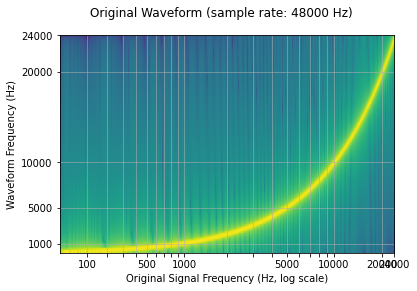

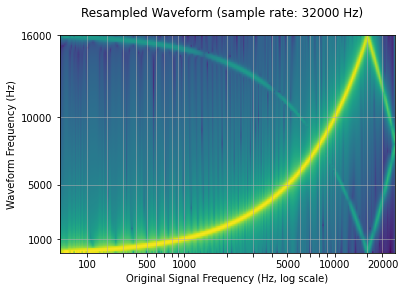

In [4]:
sample_rate = 48000
resample_rate = 32000

waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

Controling resampling quality with parameters
---------------------------------------------

Lowpass filter width
~~~~~~~~~~~~~~~~~~~~

보간에 사용되는 필터는 무한대로 확장되기 때문에 ``lowpass_filter_width`` 매개변수는 보간 창에 사용할 필터의 너비를 제어하는 ​​데 사용됩니다. 
보간은 모든 시간 단위에서 0을 통과하므로 zero crossing의 수라고도 합니다.  
더 큰 ``lowpass_filter_width``를 사용하면 더 선명하고 정확한 필터를 제공하지만 계산 비용이 더 많이 듭니다.




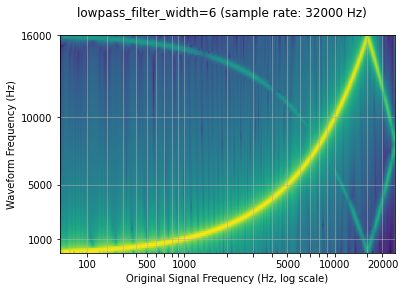

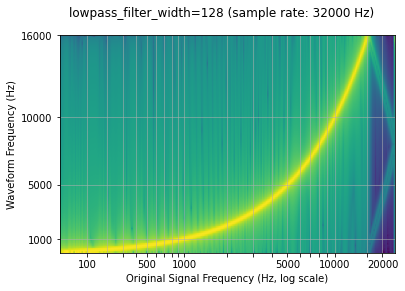

In [5]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

Rolloff
~~~~~~~

`rolloff`` 매개변수는 Nyquist 주파수의 일부로 표시되며, 이는 주어진 유한 샘플 속도로 표현할 수 있는 최대 주파수입니다.
``rolloff``는 저역 통과 필터 컷오프를 결정하고 Nyquist보다 높은 주파수가 더 낮은 주파수에 매핑될 때 발생하는 앨리어싱 정도를 제어합니다.
따라서 ``rolloff``가 낮을수록 앨리어싱의 양이 줄어들지만 일부 더 높은 주파수도 감소합니다.




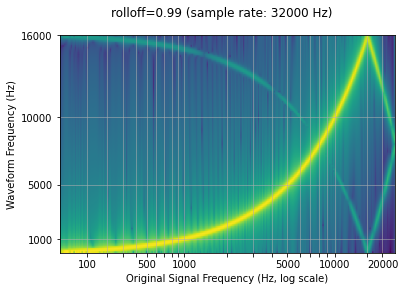

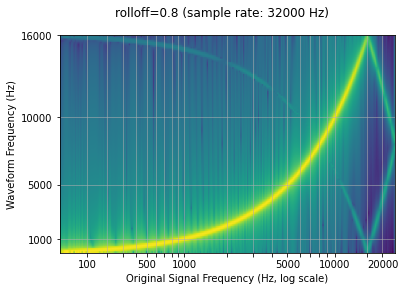

In [6]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

Window function
~~~~~~~~~~~~~~~

기본적으로 ``torchaudio``의 리샘플은 가중 코사인 함수인 Hann 윈도우 필터를 사용합니다. 
또한 필터의 부드러움과 임펄스 폭의 설계를 허용하는 추가 ``베타`` 매개변수를 포함하는 최적에 가까운 창 함수인 카이저 창을 지원합니다. 
이는 ``resampling_method`` 매개변수를 사용하여 제어할 수 있습니다.




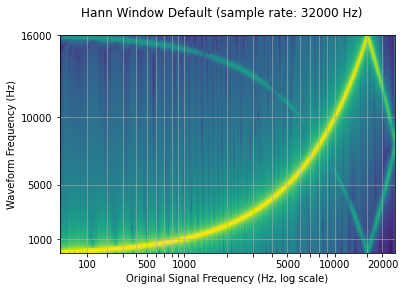

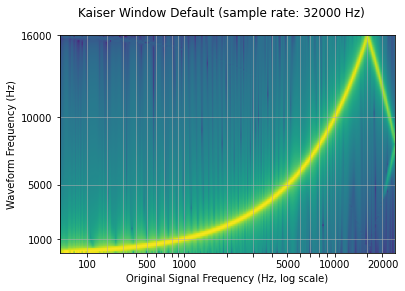

In [7]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

Comparison against librosa
--------------------------

``torchaudio``’s resample function can be used to produce results similar to
that of librosa (resampy)’s kaiser window resampling, with some noise




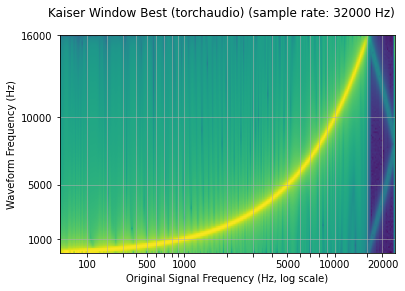

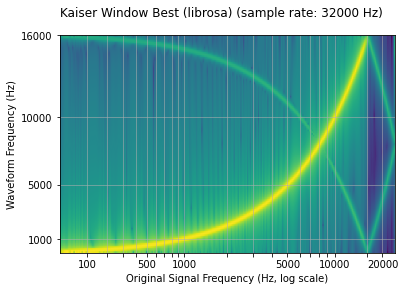

torchaudio and librosa kaiser best MSE: 2.080690115365992e-06


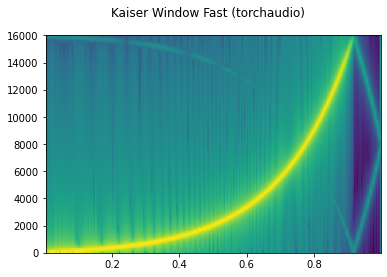

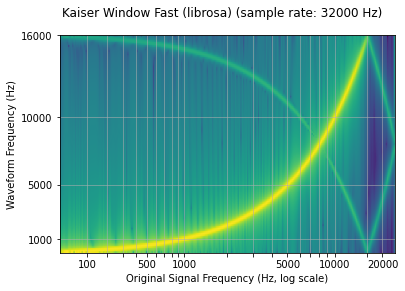

torchaudio and librosa kaiser fast MSE: 2.5200744248601027e-05


In [8]:
sample_rate = 48000
resample_rate = 32000

### kaiser_best
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_best')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

### kaiser_fast
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386
)
plot_specgram(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_fast')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

Performance Benchmarking
------------------------

Below are benchmarks for downsampling and upsampling waveforms between
two pairs of sampling rates. We demonstrate the performance implications
that the ``lowpass_filter_wdith``, window type, and sample rates can
have. Additionally, we provide a comparison against ``librosa``\ ’s
``kaiser_best`` and ``kaiser_fast`` using their corresponding parameters
in ``torchaudio``.

To elaborate on the results:

- a larger ``lowpass_filter_width`` results in a larger resampling kernel,
  and therefore increases computation time for both the kernel computation
  and convolution
- using ``kaiser_window`` results in longer computation times than the default
  ``sinc_interpolation`` because it is more complex to compute the intermediate
  window values - a large GCD between the sample and resample rate will result
  in a simplification that allows for a smaller kernel and faster kernel computation.




In [9]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
  times, rows = [], []
  sample_rate = configs[label][0]
  resample_rate = configs[label][1]
  waveform = get_sine_sweep(sample_rate)

  # sinc 64 zero-crossings
  f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
  t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
  times.append([None, 1000 * f_time, 1000 * t_time])
  rows.append(f"sinc (width 64)")

  # sinc 6 zero-crossings
  f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
  t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
  times.append([None, 1000 * f_time, 1000 * t_time])
  rows.append(f"sinc (width 16)")

  # kaiser best
  lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
  f_time = benchmark_resample(
      "functional",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=64,
      rolloff=0.9475937167399596,
      resampling_method="kaiser_window",
      beta=14.769656459379492)
  t_time = benchmark_resample(
      "transforms",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=64,
      rolloff=0.9475937167399596,
      resampling_method="kaiser_window",
      beta=14.769656459379492)
  times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
  rows.append(f"kaiser_best")

  # kaiser fast
  lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
  f_time = benchmark_resample(
      "functional",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=16,
      rolloff=0.85,
      resampling_method="kaiser_window",
      beta=8.555504641634386)
  t_time = benchmark_resample(
      "transforms",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=16,
      rolloff=0.85,
      resampling_method="kaiser_window",
      beta=8.555504641634386)
  times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
  rows.append(f"kaiser_fast")

  df = pd.DataFrame(times,
                    columns=["librosa", "functional", "transforms"],
                    index=rows)
  df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"],df.columns])
  display(df.round(2))

downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN      26.68       2.47
sinc (width 16)                                   NaN      33.53       1.97
kaiser_best                                     75.73      39.61       2.87
kaiser_fast                                     19.10      47.89       1.96

downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN      21.63      16.06
sinc (width 16)                                NaN       2.25       1.89
kaiser_best                                  12.59       7.86       7.41
kaiser_fast                                   4.17       2.66       2.13

upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN      17.52       1.80
sinc (width 16)                                 NaN      17.46       1.27
kaiser_best                                   34.60      23.70       1.91
kaiser_fast                                    9.52      23.64       1.31

upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       3.30       2.85
sinc (width 16)                              NaN       1.14       0.76
kaiser_best                                13.01       3.41       2.49
kaiser_fast                                 4.28       1.39       0.86